# Import

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
from selenium.webdriver.support import expected_conditions as EC, wait
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support.ui import WebDriverWait
import requests
import os
import sys
import pyodbc
import matplotlib.pyplot as plt
import numpy as np

# Download CSV File

In [2]:
# open covid data website
path = r"C:\Users\Abdulkadir\Documents\Programming\chromedriver.exe"
driver = webdriver.Chrome(path)
driver.get('https://ourworldindata.org/covid-deaths')
wait = WebDriverWait(driver, 5)


# download csv file
try:
    csvLink = wait.until(EC.presence_of_element_located((By.XPATH, "/html/body/main/article/div[3]/div[2]/div/div/section[1]/div/div[1]/div[1]/div/div/a[2]")))
    csvLink.click()
except:
    print('Download failed')
    sys.exit()

    
# file path of csv
filepath = r"C:\Users\Abdulkadir\Downloads\owid-covid-data.csv"


# load csv file into df
x = 1
while True:
    try:
        csv = pd.read_csv(filepath)
        print('CSV succesfully downloaded.')
        break
    except:
        print(f'CSV downloading... {x}/100.')
        x += 1
        time.sleep(3)
    
    if x == 30:
        print('CSV Failed')
        #sys.exit()

# close driver
driver.close()
        
# delete the csv file off my computer so it does not interfere with downlaoding new data and names
try:
    os.remove(filepath)
    print('CSV successfully deleted.')
except:
    print('CSV does not exist.')

CSV downloading... 1/100.
CSV downloading... 2/100.
CSV downloading... 3/100.
CSV downloading... 4/100.
CSV succesfully downloaded.
CSV successfully deleted.


# Take Relevant Data

In [104]:
data = csv[['continent', 'location', 'date', 'population', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations', 'new_vaccinations']]

# make NaN into 0
data = data.fillna(0)
data

,continent,location,date,population,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
0,Asia,Afghanistan,2020-02-24,39835428.0,5.0,5.0,0.0,0.0,0.0,0.0
1,Asia,Afghanistan,2020-02-25,39835428.0,5.0,0.0,0.0,0.0,0.0,0.0
2,Asia,Afghanistan,2020-02-26,39835428.0,5.0,0.0,0.0,0.0,0.0,0.0
3,Asia,Afghanistan,2020-02-27,39835428.0,5.0,0.0,0.0,0.0,0.0,0.0
4,Asia,Afghanistan,2020-02-28,39835428.0,5.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
177376,Africa,Zimbabwe,2022-04-04,15092171.0,246612.0,87.0,5451.0,5.0,9770202.0,75737.0
177377,Africa,Zimbabwe,2022-04-05,15092171.0,246744.0,132.0,5451.0,0.0,9807529.0,37327.0
177378,Africa,Zimbabwe,2022-04-06,15092171.0,246803.0,59.0,5453.0,2.0,9859654.0,52125.0
177379,Africa,Zimbabwe,2022-04-07,15092171.0,246870.0,67.0,5455.0,2.0,9884783.0,25129.0


# Move Data to SQL

In [105]:
SERVER_NAME = 'DESKTOP-GR6T3L7'
DATABASE_NAME = 'Covid Project'

# connection string
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER=' + SERVER_NAME + '; \
                       DATABASE=' + DATABASE_NAME + '; \
                       Trusted_Connection=yes')

# cursor to extract data
cursor = conn.cursor()

# clear SQL table for new data
cursor.execute('DELETE FROM [Covid Project].[dbo].[Automation]')
print('Table cleared from SQL')

# insert new data into table
for index, row in data.iterrows():
    cursor.execute("INSERT INTO [Covid Project].[dbo].[Automation] (continent,location,date,population,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations) values(?,?,?,?,?,?,?,?,?,?)", row.continent, row.location, row.date, row.population, row.total_cases, row.new_cases, row.total_deaths, row.new_deaths, row.total_vaccinations, row.new_vaccinations)
cursor.commit()
print('New data uploaded to SQL')

# close connection adn remove cursor
cursor.close()
conn.close()

Table cleared from SQL
New data uploaded to SQL


# Analysis using Pandas

------------------------- Deaths per cases in the United Kingdom -------------------------

In [106]:
# Finding the percentage of total deaths per total case for each day in the uk
DeathsPerCase = (data['total_deaths'] / data['total_cases']) * 100

# make it into df
DeathsPerCase = pd.DataFrame(DeathsPerCase, columns=['deaths_per_cases'])

# data needed
table_1 = data[['location', 'date', 'total_cases', 'total_deaths']]

# combines the new variable column to table 1
first_analysis = table_1.join(DeathsPerCase)

# filter data for only location in united kingdom
is_UK = first_analysis['location'] == 'United Kingdom'
first_analysis = first_analysis[is_UK]
first_analysis

,location,date,total_cases,total_deaths,deaths_per_cases
166294,United Kingdom,2020-01-31,2.0,0.0,0.000000
166295,United Kingdom,2020-02-01,2.0,0.0,0.000000
166296,United Kingdom,2020-02-02,2.0,0.0,0.000000
166297,United Kingdom,2020-02-03,8.0,0.0,0.000000
166298,United Kingdom,2020-02-04,8.0,0.0,0.000000
...,...,...,...,...,...
167088,United Kingdom,2022-04-04,21428717.0,165931.0,0.774339
167089,United Kingdom,2022-04-05,21479718.0,166304.0,0.774237
167090,United Kingdom,2022-04-06,21531180.0,169251.0,0.786074
167091,United Kingdom,2022-04-07,21578364.0,169569.0,0.785829


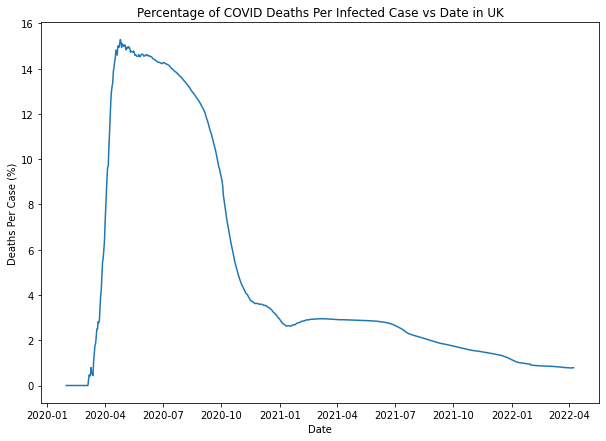

In [107]:
# change x axis incrementation because it is too much: do this by changing string date to datetime
first_analysis['date'] = pd.to_datetime(first_analysis['date'])

# make plot bigger
big = plt.figure()
big.set_figwidth(10)
big.set_figheight(7)

# labelling
plt.title('Percentage of COVID Deaths Per Infected Case vs Date in UK')
plt.xlabel('Date')
plt.ylabel("Deaths Per Case (%)")

# line graph
plt.plot(first_analysis.date, first_analysis.deaths_per_cases)

# show
plt.show()

-------------------- Percentage of total cases in the United Kingdom vs Time --------------------

In [108]:
# total cases per popualtion variable
TotCasesPerPopPerc = (data['total_cases'] / data['population']) * 100
TotCasesPerPopPerc = pd.DataFrame(TotCasesPerPopPerc, columns=['total_cases_per_population_percentage'])

second_analysis = data[['location', 'date']].join(TotCasesPerPopPerc)
second_analysis = second_analysis[is_UK]
second_analysis

,location,date,total_cases_per_population_percentage
166294,United Kingdom,2020-01-31,0.000003
166295,United Kingdom,2020-02-01,0.000003
166296,United Kingdom,2020-02-02,0.000003
166297,United Kingdom,2020-02-03,0.000012
166298,United Kingdom,2020-02-04,0.000012
...,...,...,...
167088,United Kingdom,2022-04-04,31.417129
167089,United Kingdom,2022-04-05,31.491903
167090,United Kingdom,2022-04-06,31.567352
167091,United Kingdom,2022-04-07,31.636530


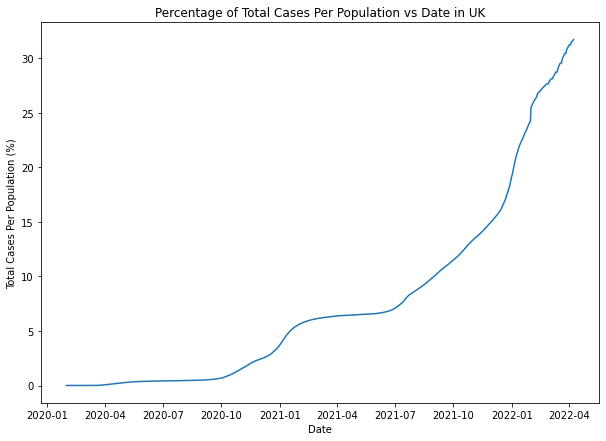

In [109]:
# change x axis incrementation because it is too much: do this by changing string date to datetime
second_analysis['date'] = pd.to_datetime(second_analysis['date'])

# make plot bigger
big = plt.figure()
big.set_figwidth(10)
big.set_figheight(7)

# labelling
plt.title('Percentage of Total Cases Per Population vs Date in UK')
plt.xlabel('Date')
plt.ylabel("Total Cases Per Population (%)")

# line graph
plt.plot(second_analysis.date, second_analysis.total_cases_per_population_percentage)

# show
plt.show()

-------------------- Death percentage in the world -------------------------

In [111]:
# relevant data
third_analysis = data[['continent', 'location', 'new_cases', 'new_deaths']]
third_analysis

# group by location and continent
is_grouped = third_analysis.groupby(['location', 'continent']).sum()
is_grouped.rename(columns={"new_cases":"total_cases", "new_deaths":"total_deaths"}, inplace=True)

# death percentage
deathPercentage = (is_grouped['total_deaths'] / is_grouped['total_cases']) * 100
deathPercentage = pd.DataFrame(deathPercentage, columns=['death_percentage'])

# combine death percentage to grouped table
combined_table = is_grouped.join(deathPercentage)

# remove NaN
combined_table['death_percentage'] = combined_table['death_percentage'].fillna(0)

# remove continent with values of 0 to get rid of continents and only leave countries
death_percentage_table = combined_table.query("continent!=0")

# remove death percentage
death_percentage_table = death_percentage_table[death_percentage_table['death_percentage'] > 0]

# sort table by total_deaths desc
death_percentage_table.sort_values(by='total_deaths', ascending=False, inplace=True)

# fixes grouping issues and accessing grouped columns
death_percentage_table.reset_index(inplace=True)
death_percentage_table

,location,continent,total_cases,total_deaths,death_percentage
0,United States,North America,80386634.0,985205.0,1.225583
1,Brazil,South America,30020458.0,661377.0,2.203088
2,India,Asia,43034217.0,514283.0,1.195056
3,Russia,Europe,17707591.0,363731.0,2.054096
4,Mexico,North America,5719829.0,316534.0,5.533977
...,...,...,...,...,...
203,Palau,Oceania,4098.0,6.0,0.146413
204,Vanuatu,Oceania,4922.0,3.0,0.060951
205,Samoa,Oceania,3320.0,3.0,0.090361
206,Montserrat,North America,176.0,3.0,1.704545


Visualisation

-------------------- Infection rate by looking at total cases against population -------------------------

In [ ]:
# Relevant data
fourth_analysis = data[['continent', 'location', 'population', 'total_cases']]

# Infection rate: Max total cases / population, group by continent location population
is_grouped_2 = fourth_analysis.groupby(['location', 'continent']).max()

# Infection rate
infection_rate = (is_grouped_2['total_cases'] / is_grouped_2['population'])*100
infection_rate = pd.DataFrame(infection_rate, columns=['infection_rate'])

# Combine the column with the table
combined_table_2 = is_grouped_2.join(infection_rate)
combined_table_2.sort_values(by=['infection_rate'], ascending=False, inplace=True)

# remove continent with values of 0 to get rid of continents and only leave countries
combined_table_2 = combined_table_2.query("continent!=0 and total_cases!=0")

# remove NaN
combined_table_2['infection_rate'] = combined_table_2['infection_rate'].fillna(0)
combined_table_2

# fixes grouping issues and accessing grouped columns
combined_table_2.reset_index(inplace=True)
combined_table_2

In [15]:
# another world map

-------------------- Death percentage for each country --------------------

In [16]:
# Relevant data#
fifth_analysis = data[['location', 'continent', 'population', 'total_deaths']]
fifth_analysis.head(50)

# Group data
is_grouped_3 = fifth_analysis.groupby(['location', 'continent']).max()

# Total deaths per population
deaths_per_population = (is_grouped_3['total_deaths'] / is_grouped_3['population'])*100
deaths_per_population = pd.DataFrame(deaths_per_population, columns=['deaths_per_population_percentage'])

# Join deaths per population to table
combined_table_3 = is_grouped_3.join(deaths_per_population)
combined_table_3.sort_values(by=['total_deaths'], ascending=False, inplace=True)

# remove continent with values of 0 to get rid of continents and only leave countries
combined_table_3 = combined_table_3.query("continent!=0 and total_deaths!=0")

# remove NaN
combined_table_3['deaths_per_population_percentage'] = combined_table_3['deaths_per_population_percentage'].fillna(0)
combined_table_3

# fixes grouping issues and accessing grouped columns
combined_table_3.reset_index(inplace=True)
combined_table_3

,location,continent,population,total_deaths,deaths_per_population_percentage
0,United States,North America,3.329151e+08,985205.0,0.295933
1,Brazil,South America,2.139934e+08,661377.0,0.309064
2,India,Asia,1.393409e+09,521656.0,0.037437
3,Russia,Europe,1.459120e+08,363731.0,0.249281
4,Mexico,North America,1.302622e+08,323595.0,0.248418
...,...,...,...,...,...
203,Palau,Oceania,1.817400e+04,6.0,0.033014
204,Vanuatu,Oceania,3.144640e+05,3.0,0.000954
205,Montserrat,North America,4.981000e+03,3.0,0.060229
206,Samoa,Oceania,2.001440e+05,3.0,0.001499


In [17]:
# another world map

-------------------- Continental Death Count --------------------

In [18]:
# relevant data
sixth_analysis = data[['location', 'continent', 'total_deaths']]

# group data
is_grouped_5 = sixth_analysis.groupby(['location', 'continent']).max()

# keep continents only
is_grouped_5 = is_grouped_5.query("continent==0")
is_grouped_5.sort_values(by=['total_deaths'], ascending=False, inplace=True)

# only keep europe, north america, asia, south america, africa, oceania
is_grouped_5 = is_grouped_5.query("(location=='Europe') | (location=='North America') | (location=='Asia') | (location=='South America') | (location=='Africa') | (location=='Oceania')")
is_grouped_5

# fixes grouping issues and accessing grouped columns
is_grouped_5.reset_index(inplace=True)
is_grouped_5

,location,continent,total_deaths
0,Europe,0,1787972.0
1,North America,0,1419732.0
2,Asia,0,1414712.0
3,South America,0,1290185.0
4,Africa,0,252223.0
5,Oceania,0,9610.0


-------------------- World Death percentage vs Date --------------------

In [19]:
# relevant data
seventh_analysis = data[['location', 'date', 'new_cases', 'new_deaths']]

# world data
world_data = seventh_analysis.query("(location=='World') and (new_cases!=0)")
world_data

,location,date,new_cases,new_deaths
174343,World,2020-01-23,100.0,1.0
174344,World,2020-01-24,287.0,8.0
174345,World,2020-01-25,493.0,16.0
174346,World,2020-01-26,683.0,14.0
174347,World,2020-01-27,809.0,26.0
...,...,...,...,...
175145,World,2022-04-04,900535.0,2926.0
175146,World,2022-04-05,1336471.0,4011.0
175147,World,2022-04-06,1453524.0,4650.0
175148,World,2022-04-07,1209196.0,4191.0


In [20]:
# line graph

-------------------- World Cases and Deaths --------------------

In [21]:
grouped_world_data = world_data.groupby(['location']).sum()
grouped_world_data.rename(columns={"new_cases":"total_cases", "new_deaths":"total_deaths"}, inplace=True)

# death percentage
world_death_percentage = (grouped_world_data['total_deaths'] / grouped_world_data['total_cases'])*100
world_death_percentage = pd.DataFrame(world_death_percentage, columns=['death_percentage'])

# join two tables
world_data_final = grouped_world_data.join(world_death_percentage)
world_data_final

# fixes grouping issues and accessing grouped columns
world_data_final.reset_index(inplace=True)
world_data_final

,location,total_cases,total_deaths,death_percentage
0,World,496334212.0,6133782.0,1.235817


-------------------- Population and Vaccinations --------------------

In [22]:
# relevant data
eighth_analysis = data[['location', 'continent', 'date', 'population', 'total_vaccinations']]
eighth_analysis

# group by location
is_grouped_6 = eighth_analysis.groupby(['location', 'continent']).max()
is_grouped_6

# vaccination percentage
vaccination_percentage = (is_grouped_6['total_vaccinations'] / is_grouped_6['population'])*100
vaccination_percentage = pd.DataFrame(vaccination_percentage, columns=['vaccination_percentage'])

# join tables
combined_4 = is_grouped_6.join(vaccination_percentage)

# keep continents only
combined_4 = combined_4.query("continent!=0 and population != 0 and total_vaccinations != 0")
combined_4.sort_values(by=['vaccination_percentage'], ascending=False, inplace=True)

# fixes grouping issues and accessing grouped columns
combined_4.reset_index(inplace=True)
combined_4

,location,continent,date,population,total_vaccinations,vaccination_percentage
0,Gibraltar,Europe,2022-04-08,33691.0,118741.0,352.441305
1,Cuba,North America,2022-04-08,11317498.0,35471647.0,313.423046
2,Chile,South America,2022-04-08,19212362.0,51119081.0,266.073901
3,Niue,Oceania,2022-03-13,1614.0,4161.0,257.806691
4,Singapore,Asia,2022-04-08,5453600.0,13864639.0,254.229115
...,...,...,...,...,...,...
213,South Sudan,Africa,2022-04-08,11381377.0,575057.0,5.052614
214,Yemen,Asia,2022-04-08,30490639.0,807502.0,2.648360
215,Haiti,North America,2022-04-08,11541683.0,255217.0,2.211263
216,Democratic Republic of Congo,Africa,2022-04-08,92377986.0,964948.0,1.044565


In [23]:
# world map

#  Same analysis using SQL Queries 

In [24]:
# connection string
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER=' + SERVER_NAME + '; \
                       DATABASE=' + DATABASE_NAME + '; \
                       Trusted_Connection=yes')

# cursor to extract data
cursor = conn.cursor()

------------------------- Deaths per cases in the United Kingdom -------------------------

In [25]:
query_1 = """ SELECT location, date, total_cases, total_deaths, (total_deaths/total_cases * 100) AS DeathsPerCase
              FROM [Covid Project].dbo.[Automation]
              WHERE location = 'United Kingdom'
              ORDER BY 1, 2 """

sql_result_1 = pd.read_sql(query_1, conn)
sql_result_1

,location,date,total_cases,total_deaths,DeathsPerCase
0,United Kingdom,2020-01-31,2.0,0.0,0.000000
1,United Kingdom,2020-02-01,2.0,0.0,0.000000
2,United Kingdom,2020-02-02,2.0,0.0,0.000000
3,United Kingdom,2020-02-03,8.0,0.0,0.000000
4,United Kingdom,2020-02-04,8.0,0.0,0.000000
...,...,...,...,...,...
794,United Kingdom,2022-04-04,21428717.0,165931.0,0.774339
795,United Kingdom,2022-04-05,21479718.0,166304.0,0.774237
796,United Kingdom,2022-04-06,21531180.0,169251.0,0.786074
797,United Kingdom,2022-04-07,21578364.0,169569.0,0.785829


-------------------- Percentage of total cases in the United Kingdom vs Time --------------------

In [26]:
query_2 = """ SELECT location, date, (total_cases/population * 100) AS TotalCasesPerPopulationPercentage
              FROM [Covid Project].dbo.[Automation]
              WHERE location = 'United Kingdom'
              ORDER BY 2 """

sql_result_2 = pd.read_sql(query_2, conn)
sql_result_2

,location,date,TotalCasesPerPopulationPercentage
0,United Kingdom,2020-01-31,0.000003
1,United Kingdom,2020-02-01,0.000003
2,United Kingdom,2020-02-02,0.000003
3,United Kingdom,2020-02-03,0.000012
4,United Kingdom,2020-02-04,0.000012
...,...,...,...
794,United Kingdom,2022-04-04,31.417129
795,United Kingdom,2022-04-05,31.491903
796,United Kingdom,2022-04-06,31.567352
797,United Kingdom,2022-04-07,31.636530


-------------------- Death percentage in the world -------------------------

In [27]:
query_3 = """ SELECT location, SUM(new_cases) AS TotalCases, SUM(new_deaths) AS TotalDeaths, ROUND((SUM(new_deaths)/SUM(new_cases))*100, 2) AS DeathPercentage
              FROM [Covid Project].dbo.[Automation]
              WHERE continent <> '0' -- gets rid of the continents and limits to countries
              GROUP BY location
              HAVING SUM(new_cases) > 0 AND  SUM(new_deaths) > 0 -- gets rid of NULL
              ORDER BY 3 DESC """

sql_result_3 = pd.read_sql(query_3, conn)
sql_result_3

,location,TotalCases,TotalDeaths,DeathPercentage
0,United States,80386634.0,985205.0,1.23
1,Brazil,30020458.0,661377.0,2.20
2,India,43034217.0,514283.0,1.20
3,Russia,17707591.0,363731.0,2.05
4,Mexico,5719829.0,316534.0,5.53
...,...,...,...,...
203,Palau,4098.0,6.0,0.15
204,Vanuatu,4922.0,3.0,0.06
205,Montserrat,176.0,3.0,1.70
206,Samoa,3320.0,3.0,0.09


-------------------- Infection rate by looking at total cases against population -------------------------

In [28]:
query_4 = """ SELECT location, MAX(total_cases) as MaximumCases, population, (MAX(total_cases)/population)*100 AS InfectionRate
              FROM [Covid Project].dbo.[Automation]
              WHERE continent <> '0' -- gets rid of the continents and limits to countries
              GROUP BY location, population
              HAVING SUM(new_cases) > 0 AND  SUM(CAST(new_deaths as int)) > 0 -- gets rid of NULL
              ORDER BY 4 DESC """

sql_result_4 = pd.read_sql(query_4, conn)
sql_result_4

,location,MaximumCases,population,InfectionRate
0,Faeroe Islands,34658.0,4.905300e+04,70.654190
1,Denmark,3080975.0,5.813302e+06,52.998709
2,Andorra,40328.0,7.735400e+04,52.134343
3,Gibraltar,17236.0,3.369100e+04,51.159063
4,Cyprus,454362.0,8.960050e+05,50.709762
...,...,...,...,...
203,Tanzania,33815.0,6.149844e+07,0.054985
204,Chad,7349.0,1.691498e+07,0.043447
205,Yemen,11812.0,3.049064e+07,0.038740
206,Niger,8822.0,2.513081e+07,0.035104


-------------------- Death percentage for each country --------------------

In [29]:
query_5 = """ SELECT location, MAX(CAST(total_deaths AS int)) as TotalDeathsUpToDate, population, (MAX(CAST(total_deaths AS int))/population)*100 AS TotalDeathPerPopulation
              FROM [Covid Project].dbo.[Automation]
              WHERE continent <> '0' -- gets rid of the continents and limits to countries
              GROUP BY location, population
              HAVING MAX(total_cases) > 0 AND MAX(CAST(total_deaths as int)) > 0 -- gets rid of NULL
              ORDER BY 2 DESC """

sql_result_5 = pd.read_sql(query_5, conn)
sql_result_5

,location,TotalDeathsUpToDate,population,TotalDeathPerPopulation
0,United States,985205,3.329151e+08,0.295933
1,Brazil,661377,2.139934e+08,0.309064
2,India,521656,1.393409e+09,0.037437
3,Russia,363731,1.459120e+08,0.249281
4,Mexico,323595,1.302622e+08,0.248418
...,...,...,...,...
203,Palau,6,1.817400e+04,0.033014
204,Samoa,3,2.001440e+05,0.001499
205,Vanuatu,3,3.144640e+05,0.000954
206,Montserrat,3,4.981000e+03,0.060229


-------------------- Continental Death Count --------------------

In [30]:
query_6 = """ SELECT location, MAX(CAST(total_deaths AS int)) AS TotalDeathCount
              FROM [Covid Project].dbo.Automation
              WHERE continent = '0' AND location NOT LIKE '%income%' AND location NOT LIKE '%European%' AND location NOT LIKE '%International%' AND location NOT LIKE '%World%'
              GROUP BY location
              ORDER BY 2 DESC """

sql_result_6 = pd.read_sql(query_6, conn)
sql_result_6

,location,TotalDeathCount
0,Europe,1787972
1,North America,1419732
2,Asia,1414712
3,South America,1290185
4,Africa,252223
5,Oceania,9610


-------------------- World Death percentage vs Date --------------------

In [31]:
query_7 = """ SELECT date, new_cases, new_deaths, ( new_deaths / new_cases)*100 AS DeathPercentagePerInfected
              FROM [Covid Project].dbo.Automation
              WHERE location = 'World' AND new_cases <> '0' """

sql_result_7 = pd.read_sql(query_7, conn)
sql_result_7

,date,new_cases,new_deaths,DeathPercentagePerInfected
0,2020-01-23,100.0,1.0,1.000000
1,2020-01-24,287.0,8.0,2.787456
2,2020-01-25,493.0,16.0,3.245436
3,2020-01-26,683.0,14.0,2.049780
4,2020-01-27,809.0,26.0,3.213844
...,...,...,...,...
802,2022-04-04,900535.0,2926.0,0.324918
803,2022-04-05,1336471.0,4011.0,0.300119
804,2022-04-06,1453524.0,4650.0,0.319912
805,2022-04-07,1209196.0,4191.0,0.346594


-------------------- World Cases and Deaths --------------------

In [32]:
query_8 = """ SELECT SUM(new_cases) AS TotalCases, SUM(CAST(new_deaths AS int)) AS TotalDeaths, (SUM(CAST(new_deaths AS int))/SUM(new_cases))*100 AS DeathPercentage
              FROM [Covid Project].dbo.Automation
              WHERE continent  <> '0' """

sql_result_8 = pd.read_sql(query_8, conn)
sql_result_8

,TotalCases,TotalDeaths,DeathPercentage
0,496333491.0,6133767,1.235816


-------------------- Population and Vaccinations --------------------

In [33]:
query_9 = """ SELECT location, population, MAX(total_vaccinations) as total_vaccinations, (MAX(total_vaccinations)/population)*100 AS vaccination_percentage
              FROM [Covid Project].dbo.Automation
              WHERE continent <> '0' AND total_vaccinations <> '0' AND population <> '0'
              GROUP BY location, population
              ORDER BY 4 DESC """

sql_result_9 = pd.read_sql(query_9, conn)
sql_result_9

,location,population,total_vaccinations,vaccination_percentage
0,Gibraltar,33691.0,118741.0,352.441305
1,Cuba,11317498.0,35471647.0,313.423046
2,Chile,19212362.0,51119081.0,266.073901
3,Niue,1614.0,4161.0,257.806691
4,Singapore,5453600.0,13864639.0,254.229115
...,...,...,...,...
213,South Sudan,11381377.0,575057.0,5.052614
214,Yemen,30490639.0,807502.0,2.648360
215,Haiti,11541683.0,255217.0,2.211263
216,Democratic Republic of Congo,92377986.0,964948.0,1.044565


In [34]:
# close connection and remove cursor
cursor.close()
conn.close()